In this notebook, we will go over using Wandb (weights and biases) with keras . WandB is a cloud based collaboration/visualization tool for deep learning. It can track experiments, save model checkpoints and help visualize the internal states of the model as training progresses.

This is just Tonmoy's CNN notebook with a few cells modified to incorporate WandB. 

## (i) Importing the necessary packages (no change)

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-03-18 01:20:09.918145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## (ii)(a) Loading and visualizing the dataset (no change)

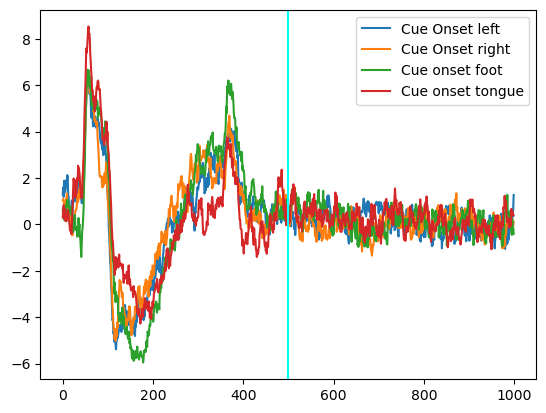

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





 # Install and Import wandb

 To use WandB, you must create an account at https://wandb.ai/site. We would recommend using the same email address for Google colab 

In [3]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/lilyzhou/.netrc


True

## (ii)(b) Preprocessing the dataset (no change)

![EEG_prep.png](attachment:EEG_prep.png)

In [4]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


## (ii)(c) Preparing the training, validation, and test datasets (no change)

In [5]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
    



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

## (iii)(CNN) Defining the architecture of a basic CNN model (no change)

In [6]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

2023-03-18 01:22:08.713413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create and run model using wandb

In [7]:
# Call wandb.init() before anything else!

run = wandb.init(project='CNN_EEG',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 5e-3,
                     "epochs": 50,
                     "batch_size": 64,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "EEG-preprocessed"
                 })
config = wandb.config 


wandb: Currently logged in as: lzhou0714 (c147). Use `wandb login --relogin` to force relogin


In [8]:
# Compiling the model
cnn_optimizer = keras.optimizers.Adam(lr=config.learning_rate)
basic_cnn_model.compile(loss=config.loss_function,
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
]

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=config.batch_size,
             epochs=config.epochs,
             validation_data=(x_valid, y_valid), callbacks=wandb_callbacks,verbose=True)
run.finish()

# When you run this, the cell output shows links to your wandb dashboard

/Users/lilyzhou/opt/anaconda3/envs/finalProject147/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.8376 - accuracy: 0.3210

INFO:tensorflow:Assets written to: my_model_01/assets


INFO:tensorflow:Assets written to: my_model_01/assets
wandb: Adding directory to artifact (./my_model_01)... Done. 0.0s


109/109 [==============================] - 5s 38ms/step - loss: 1.8376 - accuracy: 0.3210 - val_loss: 2.2342 - val_accuracy: 0.3933
Epoch 2/50
108/109 [============================>.] - ETA: 0s - loss: 1.3919 - accuracy: 0.4103

INFO:tensorflow:Assets written to: my_model_02/assets


INFO:tensorflow:Assets written to: my_model_02/assets
wandb: Adding directory to artifact (./my_model_02)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 1.3914 - accuracy: 0.4102 - val_loss: 1.2670 - val_accuracy: 0.4460
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.2539 - accuracy: 0.4787

INFO:tensorflow:Assets written to: my_model_03/assets


INFO:tensorflow:Assets written to: my_model_03/assets
wandb: Adding directory to artifact (./my_model_03)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 1.2539 - accuracy: 0.4787 - val_loss: 1.1335 - val_accuracy: 0.5127
Epoch 4/50
108/109 [============================>.] - ETA: 0s - loss: 1.1341 - accuracy: 0.5310

INFO:tensorflow:Assets written to: my_model_04/assets


INFO:tensorflow:Assets written to: my_model_04/assets
wandb: Adding directory to artifact (./my_model_04)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 1.1337 - accuracy: 0.5307 - val_loss: 1.1044 - val_accuracy: 0.5253
Epoch 5/50
108/109 [============================>.] - ETA: 0s - loss: 1.0588 - accuracy: 0.5664

INFO:tensorflow:Assets written to: my_model_05/assets


INFO:tensorflow:Assets written to: my_model_05/assets
wandb: Adding directory to artifact (./my_model_05)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 1.0603 - accuracy: 0.5661 - val_loss: 0.9869 - val_accuracy: 0.6073
Epoch 6/50
109/109 [==============================] - ETA: 0s - loss: 0.9757 - accuracy: 0.6103

INFO:tensorflow:Assets written to: my_model_06/assets


INFO:tensorflow:Assets written to: my_model_06/assets
wandb: Adding directory to artifact (./my_model_06)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.9757 - accuracy: 0.6103 - val_loss: 0.9177 - val_accuracy: 0.6160
Epoch 7/50
109/109 [==============================] - ETA: 0s - loss: 0.8944 - accuracy: 0.6453

INFO:tensorflow:Assets written to: my_model_07/assets


INFO:tensorflow:Assets written to: my_model_07/assets
wandb: Adding directory to artifact (./my_model_07)... Done. 0.0s


109/109 [==============================] - 4s 32ms/step - loss: 0.8944 - accuracy: 0.6453 - val_loss: 0.8878 - val_accuracy: 0.6447
Epoch 8/50
108/109 [============================>.] - ETA: 0s - loss: 0.8346 - accuracy: 0.6690

INFO:tensorflow:Assets written to: my_model_08/assets


INFO:tensorflow:Assets written to: my_model_08/assets
wandb: Adding directory to artifact (./my_model_08)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.8338 - accuracy: 0.6688 - val_loss: 0.8456 - val_accuracy: 0.6733
Epoch 9/50
109/109 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.6784

INFO:tensorflow:Assets written to: my_model_09/assets


INFO:tensorflow:Assets written to: my_model_09/assets
wandb: Adding directory to artifact (./my_model_09)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.8056 - accuracy: 0.6784 - val_loss: 0.8094 - val_accuracy: 0.6733
Epoch 10/50
109/109 [==============================] - ETA: 0s - loss: 0.7437 - accuracy: 0.7040

INFO:tensorflow:Assets written to: my_model_10/assets


INFO:tensorflow:Assets written to: my_model_10/assets
wandb: Adding directory to artifact (./my_model_10)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.7437 - accuracy: 0.7040 - val_loss: 0.7819 - val_accuracy: 0.7120
Epoch 11/50
108/109 [============================>.] - ETA: 0s - loss: 0.7118 - accuracy: 0.7232

INFO:tensorflow:Assets written to: my_model_11/assets


INFO:tensorflow:Assets written to: my_model_11/assets
wandb: Adding directory to artifact (./my_model_11)... Done. 0.0s


109/109 [==============================] - 4s 32ms/step - loss: 0.7108 - accuracy: 0.7239 - val_loss: 0.8119 - val_accuracy: 0.6727
Epoch 12/50
108/109 [============================>.] - ETA: 0s - loss: 0.6783 - accuracy: 0.7341

INFO:tensorflow:Assets written to: my_model_12/assets


INFO:tensorflow:Assets written to: my_model_12/assets
wandb: Adding directory to artifact (./my_model_12)... Done. 0.0s


109/109 [==============================] - 4s 35ms/step - loss: 0.6780 - accuracy: 0.7343 - val_loss: 0.9053 - val_accuracy: 0.6700
Epoch 13/50
108/109 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.7428

INFO:tensorflow:Assets written to: my_model_13/assets


INFO:tensorflow:Assets written to: my_model_13/assets
wandb: Adding directory to artifact (./my_model_13)... Done. 0.0s


109/109 [==============================] - 4s 36ms/step - loss: 0.6550 - accuracy: 0.7432 - val_loss: 0.8285 - val_accuracy: 0.6833
Epoch 14/50
109/109 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.7425

INFO:tensorflow:Assets written to: my_model_14/assets


INFO:tensorflow:Assets written to: my_model_14/assets
wandb: Adding directory to artifact (./my_model_14)... Done. 0.0s


109/109 [==============================] - 3s 32ms/step - loss: 0.6440 - accuracy: 0.7425 - val_loss: 0.7618 - val_accuracy: 0.7053
Epoch 15/50
108/109 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.7646

INFO:tensorflow:Assets written to: my_model_15/assets


INFO:tensorflow:Assets written to: my_model_15/assets
wandb: Adding directory to artifact (./my_model_15)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.6042 - accuracy: 0.7644 - val_loss: 0.7704 - val_accuracy: 0.6993
Epoch 16/50
107/109 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.7721

INFO:tensorflow:Assets written to: my_model_16/assets


INFO:tensorflow:Assets written to: my_model_16/assets
wandb: Adding directory to artifact (./my_model_16)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.5899 - accuracy: 0.7726 - val_loss: 0.7772 - val_accuracy: 0.7087
Epoch 17/50
109/109 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7787

INFO:tensorflow:Assets written to: my_model_17/assets


INFO:tensorflow:Assets written to: my_model_17/assets
wandb: Adding directory to artifact (./my_model_17)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.5645 - accuracy: 0.7787 - val_loss: 0.7976 - val_accuracy: 0.6987
Epoch 18/50
109/109 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7889

INFO:tensorflow:Assets written to: my_model_18/assets


INFO:tensorflow:Assets written to: my_model_18/assets
wandb: Adding directory to artifact (./my_model_18)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.5489 - accuracy: 0.7889 - val_loss: 0.8160 - val_accuracy: 0.6853
Epoch 19/50
109/109 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7914

INFO:tensorflow:Assets written to: my_model_19/assets


INFO:tensorflow:Assets written to: my_model_19/assets
wandb: Adding directory to artifact (./my_model_19)... Done. 0.1s


109/109 [==============================] - 4s 36ms/step - loss: 0.5352 - accuracy: 0.7914 - val_loss: 0.7434 - val_accuracy: 0.7153
Epoch 20/50
109/109 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.8076

INFO:tensorflow:Assets written to: my_model_20/assets


INFO:tensorflow:Assets written to: my_model_20/assets
wandb: Adding directory to artifact (./my_model_20)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.4997 - accuracy: 0.8076 - val_loss: 0.8004 - val_accuracy: 0.7000
Epoch 21/50
107/109 [============================>.] - ETA: 0s - loss: 0.5026 - accuracy: 0.8088

INFO:tensorflow:Assets written to: my_model_21/assets


INFO:tensorflow:Assets written to: my_model_21/assets
wandb: Adding directory to artifact (./my_model_21)... Done. 0.0s


109/109 [==============================] - 4s 32ms/step - loss: 0.5020 - accuracy: 0.8095 - val_loss: 0.8029 - val_accuracy: 0.6973
Epoch 22/50
108/109 [============================>.] - ETA: 0s - loss: 0.4971 - accuracy: 0.8092

INFO:tensorflow:Assets written to: my_model_22/assets


INFO:tensorflow:Assets written to: my_model_22/assets
wandb: Adding directory to artifact (./my_model_22)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.4965 - accuracy: 0.8098 - val_loss: 0.8225 - val_accuracy: 0.7080
Epoch 23/50
108/109 [============================>.] - ETA: 0s - loss: 0.4652 - accuracy: 0.8190

INFO:tensorflow:Assets written to: my_model_23/assets


INFO:tensorflow:Assets written to: my_model_23/assets
wandb: Adding directory to artifact (./my_model_23)... Done. 0.0s


109/109 [==============================] - 3s 31ms/step - loss: 0.4670 - accuracy: 0.8181 - val_loss: 0.7772 - val_accuracy: 0.7120
Epoch 24/50
109/109 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.8214

INFO:tensorflow:Assets written to: my_model_24/assets


INFO:tensorflow:Assets written to: my_model_24/assets
wandb: Adding directory to artifact (./my_model_24)... Done. 0.0s


109/109 [==============================] - 3s 32ms/step - loss: 0.4711 - accuracy: 0.8214 - val_loss: 0.7318 - val_accuracy: 0.7220
Epoch 25/50
108/109 [============================>.] - ETA: 0s - loss: 0.4733 - accuracy: 0.8176

INFO:tensorflow:Assets written to: my_model_25/assets


INFO:tensorflow:Assets written to: my_model_25/assets
wandb: Adding directory to artifact (./my_model_25)... Done. 0.0s


109/109 [==============================] - 3s 31ms/step - loss: 0.4728 - accuracy: 0.8175 - val_loss: 0.8076 - val_accuracy: 0.7160
Epoch 26/50
106/109 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8392

INFO:tensorflow:Assets written to: my_model_26/assets


INFO:tensorflow:Assets written to: my_model_26/assets
wandb: Adding directory to artifact (./my_model_26)... Done. 0.0s


109/109 [==============================] - 3s 31ms/step - loss: 0.4268 - accuracy: 0.8389 - val_loss: 0.8429 - val_accuracy: 0.7073
Epoch 27/50
109/109 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8427

INFO:tensorflow:Assets written to: my_model_27/assets


INFO:tensorflow:Assets written to: my_model_27/assets
wandb: Adding directory to artifact (./my_model_27)... Done. 0.0s


109/109 [==============================] - 4s 35ms/step - loss: 0.4070 - accuracy: 0.8427 - val_loss: 0.8168 - val_accuracy: 0.7087
Epoch 28/50
108/109 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8381

INFO:tensorflow:Assets written to: my_model_28/assets


INFO:tensorflow:Assets written to: my_model_28/assets
wandb: Adding directory to artifact (./my_model_28)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.4327 - accuracy: 0.8379 - val_loss: 0.8506 - val_accuracy: 0.7113
Epoch 29/50
108/109 [============================>.] - ETA: 0s - loss: 0.4298 - accuracy: 0.8354

INFO:tensorflow:Assets written to: my_model_29/assets


INFO:tensorflow:Assets written to: my_model_29/assets
wandb: Adding directory to artifact (./my_model_29)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.4305 - accuracy: 0.8349 - val_loss: 0.7766 - val_accuracy: 0.7340
Epoch 30/50
109/109 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8417

INFO:tensorflow:Assets written to: my_model_30/assets


INFO:tensorflow:Assets written to: my_model_30/assets
wandb: Adding directory to artifact (./my_model_30)... Done. 0.0s


109/109 [==============================] - 3s 31ms/step - loss: 0.4085 - accuracy: 0.8417 - val_loss: 0.7672 - val_accuracy: 0.7367
Epoch 31/50
109/109 [==============================] - ETA: 0s - loss: 0.3856 - accuracy: 0.8524

INFO:tensorflow:Assets written to: my_model_31/assets


INFO:tensorflow:Assets written to: my_model_31/assets
wandb: Adding directory to artifact (./my_model_31)... Done. 0.0s


109/109 [==============================] - 4s 35ms/step - loss: 0.3856 - accuracy: 0.8524 - val_loss: 0.8374 - val_accuracy: 0.7133
Epoch 32/50
109/109 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.8437

INFO:tensorflow:Assets written to: my_model_32/assets


INFO:tensorflow:Assets written to: my_model_32/assets
wandb: Adding directory to artifact (./my_model_32)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.4048 - accuracy: 0.8437 - val_loss: 0.8626 - val_accuracy: 0.7100
Epoch 33/50
108/109 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.8555

INFO:tensorflow:Assets written to: my_model_33/assets


INFO:tensorflow:Assets written to: my_model_33/assets
wandb: Adding directory to artifact (./my_model_33)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3858 - accuracy: 0.8555 - val_loss: 0.8159 - val_accuracy: 0.7213
Epoch 34/50
109/109 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8547

INFO:tensorflow:Assets written to: my_model_34/assets


INFO:tensorflow:Assets written to: my_model_34/assets
wandb: Adding directory to artifact (./my_model_34)... Done. 0.0s


109/109 [==============================] - 4s 36ms/step - loss: 0.3893 - accuracy: 0.8547 - val_loss: 0.8921 - val_accuracy: 0.7080
Epoch 35/50
107/109 [============================>.] - ETA: 0s - loss: 0.3644 - accuracy: 0.8648

INFO:tensorflow:Assets written to: my_model_35/assets


INFO:tensorflow:Assets written to: my_model_35/assets
wandb: Adding directory to artifact (./my_model_35)... Done. 0.0s


109/109 [==============================] - 3s 32ms/step - loss: 0.3630 - accuracy: 0.8654 - val_loss: 0.8039 - val_accuracy: 0.7353
Epoch 36/50
109/109 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8624

INFO:tensorflow:Assets written to: my_model_36/assets


INFO:tensorflow:Assets written to: my_model_36/assets
wandb: Adding directory to artifact (./my_model_36)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.3665 - accuracy: 0.8624 - val_loss: 0.9075 - val_accuracy: 0.7047
Epoch 37/50
107/109 [============================>.] - ETA: 0s - loss: 0.3603 - accuracy: 0.8567

INFO:tensorflow:Assets written to: my_model_37/assets


INFO:tensorflow:Assets written to: my_model_37/assets
wandb: Adding directory to artifact (./my_model_37)... Done. 0.0s


109/109 [==============================] - 3s 32ms/step - loss: 0.3598 - accuracy: 0.8572 - val_loss: 0.9662 - val_accuracy: 0.6893
Epoch 38/50
109/109 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8655

INFO:tensorflow:Assets written to: my_model_38/assets


INFO:tensorflow:Assets written to: my_model_38/assets
wandb: Adding directory to artifact (./my_model_38)... Done. 0.0s


109/109 [==============================] - 4s 32ms/step - loss: 0.3526 - accuracy: 0.8655 - val_loss: 0.8051 - val_accuracy: 0.7280
Epoch 39/50
109/109 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.8664

INFO:tensorflow:Assets written to: my_model_39/assets


INFO:tensorflow:Assets written to: my_model_39/assets
wandb: Adding directory to artifact (./my_model_39)... Done. 0.0s


109/109 [==============================] - 3s 32ms/step - loss: 0.3495 - accuracy: 0.8664 - val_loss: 0.7980 - val_accuracy: 0.7393
Epoch 40/50
109/109 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8734

INFO:tensorflow:Assets written to: my_model_40/assets


INFO:tensorflow:Assets written to: my_model_40/assets
wandb: Adding directory to artifact (./my_model_40)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3358 - accuracy: 0.8734 - val_loss: 0.8546 - val_accuracy: 0.7020
Epoch 41/50
109/109 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8720

INFO:tensorflow:Assets written to: my_model_41/assets


INFO:tensorflow:Assets written to: my_model_41/assets
wandb: Adding directory to artifact (./my_model_41)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3506 - accuracy: 0.8720 - val_loss: 0.8502 - val_accuracy: 0.7187
Epoch 42/50
109/109 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8744

INFO:tensorflow:Assets written to: my_model_42/assets


INFO:tensorflow:Assets written to: my_model_42/assets
wandb: Adding directory to artifact (./my_model_42)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.3395 - accuracy: 0.8744 - val_loss: 0.8219 - val_accuracy: 0.7327
Epoch 43/50
109/109 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8813

INFO:tensorflow:Assets written to: my_model_43/assets


INFO:tensorflow:Assets written to: my_model_43/assets
wandb: Adding directory to artifact (./my_model_43)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.3238 - accuracy: 0.8813 - val_loss: 0.8908 - val_accuracy: 0.7420
Epoch 44/50
108/109 [============================>.] - ETA: 0s - loss: 0.3407 - accuracy: 0.8747

INFO:tensorflow:Assets written to: my_model_44/assets


INFO:tensorflow:Assets written to: my_model_44/assets
wandb: Adding directory to artifact (./my_model_44)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3407 - accuracy: 0.8749 - val_loss: 0.8544 - val_accuracy: 0.7280
Epoch 45/50
109/109 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8818

INFO:tensorflow:Assets written to: my_model_45/assets


INFO:tensorflow:Assets written to: my_model_45/assets
wandb: Adding directory to artifact (./my_model_45)... Done. 0.0s


109/109 [==============================] - 4s 35ms/step - loss: 0.3205 - accuracy: 0.8818 - val_loss: 0.8365 - val_accuracy: 0.7333
Epoch 46/50
107/109 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.8803

INFO:tensorflow:Assets written to: my_model_46/assets


INFO:tensorflow:Assets written to: my_model_46/assets
wandb: Adding directory to artifact (./my_model_46)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3147 - accuracy: 0.8800 - val_loss: 0.8957 - val_accuracy: 0.7200
Epoch 47/50
109/109 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8743

INFO:tensorflow:Assets written to: my_model_47/assets


INFO:tensorflow:Assets written to: my_model_47/assets
wandb: Adding directory to artifact (./my_model_47)... Done. 0.0s


109/109 [==============================] - 4s 32ms/step - loss: 0.3253 - accuracy: 0.8743 - val_loss: 0.8502 - val_accuracy: 0.7413
Epoch 48/50
107/109 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8757

INFO:tensorflow:Assets written to: my_model_48/assets


INFO:tensorflow:Assets written to: my_model_48/assets
wandb: Adding directory to artifact (./my_model_48)... Done. 0.0s


109/109 [==============================] - 4s 35ms/step - loss: 0.3255 - accuracy: 0.8753 - val_loss: 0.8514 - val_accuracy: 0.7513
Epoch 49/50
108/109 [============================>.] - ETA: 0s - loss: 0.3103 - accuracy: 0.8861

INFO:tensorflow:Assets written to: my_model_49/assets


INFO:tensorflow:Assets written to: my_model_49/assets
wandb: Adding directory to artifact (./my_model_49)... Done. 0.0s


109/109 [==============================] - 4s 33ms/step - loss: 0.3099 - accuracy: 0.8861 - val_loss: 0.8467 - val_accuracy: 0.7293
Epoch 50/50
109/109 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8894

INFO:tensorflow:Assets written to: my_model_50/assets


INFO:tensorflow:Assets written to: my_model_50/assets
wandb: Adding directory to artifact (./my_model_50)... Done. 0.0s


109/109 [==============================] - 4s 34ms/step - loss: 0.3008 - accuracy: 0.8894 - val_loss: 0.8473 - val_accuracy: 0.7053


epoch/accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇███▇██▇
epoch/val_loss,█▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▂▂▂▁▁▂▁▂▂▂▂▂▂
epoch/accuracy,0.88937
epoch/epoch,49
epoch/learning_rate,0.005
epoch/loss,0.30077
epoch/val_accuracy,0.70533


# Hyper parameter tuning with WandB

In [9]:
# Define sweep parameters 
sweep_config = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'values': [1e-3, 5e-3, 1e-2]}
     }
}

In [10]:
# Entity name = username that you use to login
sweep_id = wandb.sweep(sweep_config, entity = '',project="CNN_EEG")

Create sweep with ID: yplvpwsf
Sweep URL: https://wandb.ai/c147/CNN_EEG/sweeps/yplvpwsf


In [11]:
# Define a function with model and parameters
# The wandb agent calls this function with each set of hyperparameters

def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        "batch_size": 64,
        "learning_rate": 0.01,
        "epochs" : 5
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    wandb.config.loss_function = "categorical_crossentropy"
    wandb.config.architecture_name = "CNN"
    wandb.config.dataset_name = "EEG-preprocessed"
   
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  
    # Defining the callbacks - add wandb callbacks 
    wandb_callbacks = [[WandbCallback(monitor='val_loss', validation_data=(x_valid, y_valid))],
    WandbMetricsLogger()
]
  

    cnn_optimizer = keras.optimizers.Adam(lr=config.learning_rate)
    basic_cnn_model.compile(loss=config.loss_function,
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=config.batch_size,
             epochs=config.epochs,
             validation_data=(x_valid, y_valid), callbacks=wandb_callbacks,verbose=True)
    

   

In [12]:
# Perform the sweep operation
wandb.agent(sweep_id, function=train, count=2)

wandb: Agent Starting Run: n0cm00z1 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.005


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10


/Users/lilyzhou/opt/anaconda3/envs/finalProject147/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


430/435 [============================>.] - ETA: 0s - loss: 1.9906 - accuracy: 0.3275

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 1.9835 - accuracy: 0.3286 - val_loss: 1.2260 - val_accuracy: 0.3993
Epoch 2/10
434/435 [============================>.] - ETA: 0s - loss: 1.2418 - accuracy: 0.4469

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 1.2420 - accuracy: 0.4468 - val_loss: 1.0987 - val_accuracy: 0.5320
Epoch 3/10
435/435 [==============================] - 3s 8ms/step - loss: 1.1297 - accuracy: 0.5112 - val_loss: 1.1163 - val_accuracy: 0.5253
Epoch 4/10
435/435 [==============================] - 3s 8ms/step - loss: 1.0593 - accuracy: 0.5533 - val_loss: 1.1255 - val_accuracy: 0.5827
Epoch 5/10
431/435 [============================>.] - ETA: 0s - loss: 1.0264 - accuracy: 0.5776

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 1.0276 - accuracy: 0.5769 - val_loss: 0.9821 - val_accuracy: 0.5947
Epoch 6/10
429/435 [============================>.] - ETA: 0s - loss: 0.9693 - accuracy: 0.6029

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.9701 - accuracy: 0.6029 - val_loss: 0.8840 - val_accuracy: 0.6260
Epoch 7/10
435/435 [==============================] - 3s 8ms/step - loss: 0.9410 - accuracy: 0.6239 - val_loss: 0.9150 - val_accuracy: 0.6280
Epoch 8/10
435/435 [==============================] - 3s 8ms/step - loss: 0.9280 - accuracy: 0.6293 - val_loss: 0.9141 - val_accuracy: 0.6360
Epoch 9/10
433/435 [============================>.] - ETA: 0s - loss: 0.8821 - accuracy: 0.6497

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.8821 - accuracy: 0.6494 - val_loss: 0.8789 - val_accuracy: 0.6587
Epoch 10/10
432/435 [============================>.] - ETA: 0s - loss: 0.8760 - accuracy: 0.6590

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012527-n0cm00z1/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 0.8772 - accuracy: 0.6582 - val_loss: 0.8724 - val_accuracy: 0.6627


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch/accuracy,▁▄▅▆▆▇▇▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁
epoch/val_accuracy,▁▅▄▆▆▇▇▇██
epoch/val_loss,█▅▆▆▃▁▂▂▁▁
loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▄▆▆▇▇▇██
val_loss,█▅▆▆▃▁▂▂▁▁


wandb: Agent Starting Run: gjvuk46i with config:
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	lr: 0.005


Epoch 1/15


/Users/lilyzhou/opt/anaconda3/envs/finalProject147/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


428/435 [============================>.] - ETA: 0s - loss: 2.0026 - accuracy: 0.3268

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 1.9898 - accuracy: 0.3292 - val_loss: 1.2522 - val_accuracy: 0.4100
Epoch 2/15
433/435 [============================>.] - ETA: 0s - loss: 1.2443 - accuracy: 0.4452

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 1.2442 - accuracy: 0.4450 - val_loss: 1.1712 - val_accuracy: 0.4540
Epoch 3/15
433/435 [============================>.] - ETA: 0s - loss: 1.1839 - accuracy: 0.4671

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 1.1830 - accuracy: 0.4675 - val_loss: 1.1027 - val_accuracy: 0.4993
Epoch 4/15
435/435 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.5257

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 1.1198 - accuracy: 0.5257 - val_loss: 1.0872 - val_accuracy: 0.5080
Epoch 5/15
435/435 [==============================] - 4s 8ms/step - loss: 1.0741 - accuracy: 0.5543 - val_loss: 1.1163 - val_accuracy: 0.4793
Epoch 6/15
431/435 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.5779

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 1.0202 - accuracy: 0.5782 - val_loss: 0.9747 - val_accuracy: 0.6087
Epoch 7/15
435/435 [==============================] - 4s 8ms/step - loss: 0.9880 - accuracy: 0.5950 - val_loss: 0.9896 - val_accuracy: 0.6067
Epoch 8/15
432/435 [============================>.] - ETA: 0s - loss: 0.9437 - accuracy: 0.6247

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.9451 - accuracy: 0.6244 - val_loss: 0.9633 - val_accuracy: 0.5993
Epoch 9/15
433/435 [============================>.] - ETA: 0s - loss: 0.9126 - accuracy: 0.6347

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.9122 - accuracy: 0.6348 - val_loss: 0.9027 - val_accuracy: 0.6520
Epoch 10/15
432/435 [============================>.] - ETA: 0s - loss: 0.8911 - accuracy: 0.6445

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.8909 - accuracy: 0.6448 - val_loss: 0.8113 - val_accuracy: 0.6487
Epoch 11/15
435/435 [==============================] - 4s 8ms/step - loss: 0.8698 - accuracy: 0.6565 - val_loss: 0.8416 - val_accuracy: 0.6600
Epoch 12/15
435/435 [==============================] - 3s 8ms/step - loss: 0.8332 - accuracy: 0.6766 - val_loss: 0.8244 - val_accuracy: 0.6673
Epoch 13/15
433/435 [============================>.] - ETA: 0s - loss: 0.8398 - accuracy: 0.6725

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 12ms/step - loss: 0.8405 - accuracy: 0.6723 - val_loss: 0.8005 - val_accuracy: 0.6893
Epoch 14/15
435/435 [==============================] - 3s 8ms/step - loss: 0.8207 - accuracy: 0.6779 - val_loss: 0.8577 - val_accuracy: 0.6480
Epoch 15/15
434/435 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.6891

INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lilyzhou/Desktop/Winter 2023/ECE C147/project/wandb/run-20230318_012628-gjvuk46i/files/model-best)... Done. 0.0s


435/435 [==============================] - 5s 11ms/step - loss: 0.8026 - accuracy: 0.6892 - val_loss: 0.7919 - val_accuracy: 0.6740


accuracy,▁▃▄▅▅▆▆▇▇▇▇████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/accuracy,▁▃▄▅▅▆▆▇▇▇▇████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▂▃▃▃▆▆▆▇▇▇▇█▇█
epoch/val_loss,█▇▆▅▆▄▄▄▃▁▂▁▁▂▁
loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▃▃▆▆▆▇▇▇▇█▇█
val_loss,█▇▆▅▆▄▄▄▃▁▂▁▁▂▁


## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [13]:
# Model parameters
learning_rate = 1e-3
epochs = 50


## (vi)(CNN) Visualizing the accuracy and loss trajectory

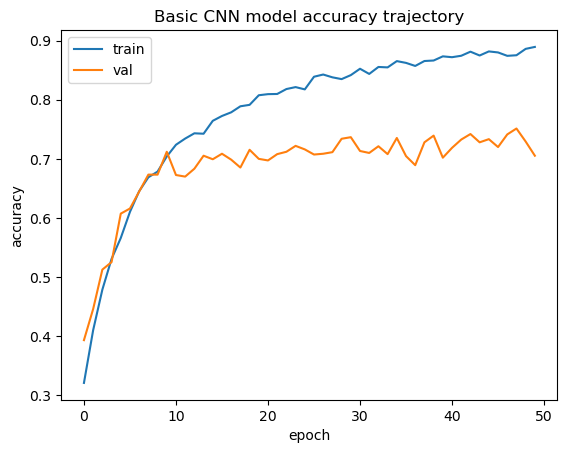

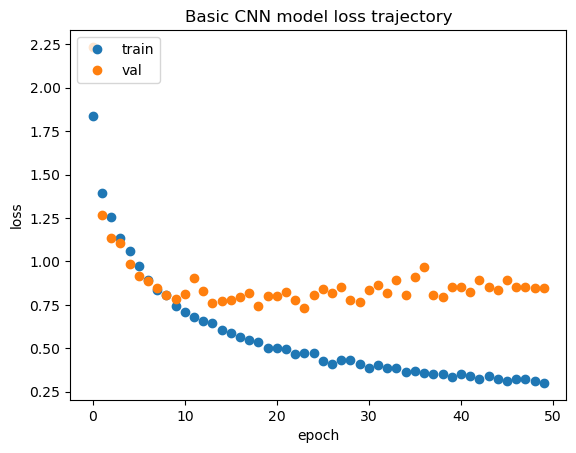

In [14]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [15]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6755079030990601
